# **Generative Answer Chat Bot**

In [165]:
import re

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

In [90]:
questions = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Questions.csv', parse_dates = True, encoding='latin-1')
answers = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Answers.csv', parse_dates=True, encoding='latin-1')
tags = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Tags.csv', encoding='latin-1')

In [91]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            607282 non-null  int64  
 1   OwnerUserId   601070 non-null  float64
 2   CreationDate  607282 non-null  object 
 3   Score         607282 non-null  int64  
 4   Title         607282 non-null  object 
 5   Body          607282 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 27.8+ MB


In [92]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            987122 non-null  int64  
 1   OwnerUserId   981755 non-null  float64
 2   CreationDate  987122 non-null  object 
 3   ParentId      987122 non-null  int64  
 4   Score         987122 non-null  int64  
 5   Body          987122 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 45.2+ MB


In [93]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885078 entries, 0 to 1885077
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 28.8+ MB


In [94]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [95]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [96]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


## **Prepare Data**

### Convert columns to snake case

In [101]:
# Questions columns
questions.columns = (questions.columns
                     .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                     .str.lower())

questions.columns

Index(['id', 'owner_user_id', 'creation_date', 'score', 'title', 'body'], dtype='object')

In [103]:
# Answers columns
answers.columns = (answers.columns
                   .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                   .str.lower())

answers.columns

Index(['id', 'owner_user_id', 'creation_date', 'parent_id', 'score', 'body'], dtype='object')

In [104]:
# Tags columns
tags.columns = tags.columns.str.lower()

tags.columns

Index(['id', 'tag'], dtype='object')

### Convert to datetime

In [129]:
# Questions date to datetime
questions['creation_date'] = pd.to_datetime(questions['creation_date'])

display(questions.head())
questions.info()

,id,owner_user_id,creation_date,score,title,body,body_normalized,title_normalized
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,i am using the photoshop's javascript api to f...,how can i find the full path to a font from it...
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,i have a cross platform python application whi...,get a preview of a on windows
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,there are several ways to iterate over a resul...,cx_oracle how do i iterate over a result set
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                607282 non-null  int64              
 1   owner_user_id     601070 non-null  float64            
 2   creation_date     607282 non-null  datetime64[ns, UTC]
 3   score             607282 non-null  int64              
 4   title             607282 non-null  object             
 5   body              607282 non-null  object             
 6   body_normalized   607282 non-null  object             
 7   title_normalized  607282 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(4)
memory usage: 37.1+ MB


In [130]:
# Answers date to datetime
answers['creation_date'] = pd.to_datetime(answers['creation_date'])

display(answers.head())
answers.info()

,id,owner_user_id,creation_date,parent_id,score,body,body_normalized
0,497,50.0,2008-08-02 16:56:53+00:00,469,4,<p>open up a terminal (Applications-&gt;Utilit...,open up a terminal applications gt utilities g...
1,518,153.0,2008-08-02 17:42:28+00:00,469,2,<p>I haven't been able to find anything that d...,i haven't been able to find anything that does...
2,536,161.0,2008-08-02 18:49:07+00:00,502,9,<p>You can use ImageMagick's convert utility f...,you can use imagemagick's convert utility for ...
3,538,156.0,2008-08-02 18:56:56+00:00,535,23,<p>One possibility is Hudson. It's written in...,one possibility is hudson it's written in java...
4,541,157.0,2008-08-02 19:06:40+00:00,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",we run http buildbot net trac buildbot trac at...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id               987122 non-null  int64              
 1   owner_user_id    981755 non-null  float64            
 2   creation_date    987122 non-null  datetime64[ns, UTC]
 3   parent_id        987122 non-null  int64              
 4   score            987122 non-null  int64              
 5   body             987122 non-null  object             
 6   body_normalized  987122 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 52.7+ MB


### Missing values

In [157]:
questions.isna().sum()

id                     0
owner_user_id       6212
creation_date          0
score                  0
title                  0
body                   0
body_normalized        0
title_normalized       0
creation_year          0
dtype: int64

In [158]:
answers.isna().sum()

id                    0
owner_user_id      5367
creation_date         0
parent_id             0
score                 0
body                  0
body_normalized       0
creation_year         0
dtype: int64

### Duplicates

In [86]:
# Questions duplicates
print(f'Number of questions duplicates: {questions.duplicated().sum()}')

Number of questions duplicates: 0


In [85]:
# Ansers duplicates
print(f'Number of answer duplicates: {answers.duplicated().sum()}')

Number of answer duplicates: 0


### Normalize text

In [124]:
# View text example
print(questions.loc[1, 'body'])
print(questions.loc[2, 'body'])

print(answers.loc[1, 'body'])
print(answers.loc[2, 'body'])

<p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

<p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to CruiseControl or TeamCity.</p>

<p>I realize I could do this with hooks in most VCSes, but that requires that the tests run on the same machine as the version control server, which isn't as elegant as I would like. Does anyone have any suggestions for a small, user-friendly, open-source continuous integration system suitable for a Python codebase?</p>

<p>I haven't been able to find anything that does this direc

In [175]:
# Define normalizing function
def normalize_text(text):
    text = text.lower()
    text = text.replace('<p>', ' ')
    text = text.replace('</p>', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('<a', ' ')
    text = text.replace('</a>', ' ')
    text = text.replace('href=', ' ')
    text = text.replace('</code', ' ')
    text = text.replace('</pre>', ' ')
    text = text.replace('<code>', ' ')
    text = text.replace('jpeg', ' ')
    text = text.replace('jpg', ' ')
    text = text.replace('pre', ' ')
    text = text.replace('pdf', ' ')
    text = re.sub(r"[^a-zA-z']", ' ', text)
    text = text.split()
    text = " ".join(text)
    
    return text

# Apply normalization to Q title and Q & A body
questions['body_normalized'] = questions['body'].apply(normalize_text)
questions['title_normalized'] = questions['title'].apply(normalize_text)
answers['body_normalized'] = answers['body'].apply(normalize_text)

In [127]:
# View examples normalized
print(questions.loc[1, 'title_normalized'])
print(questions.loc[1, 'body_normalized'])
print(answers.loc[1, 'body_normalized'])

get a preview of a on windows
i have a cross platform python application which needs to generate a preview of the first page of a on the mac i am spawning http developer apple com documentation darwin reference manpages man sips html sips is there something similarly simple i can do on windows
i haven't been able to find anything that does this directly i think you'll have to iterate through the various font folders on the system system library fonts library fonts and there can probably be a user level directory as well library fonts


### Add year column

In [133]:
# Question year
questions['creation_year'] = questions['creation_date'].dt.year

questions.head()

,id,owner_user_id,creation_date,score,title,body,body_normalized,title_normalized,creation_year
0,469,147.0,2008-08-02 15:11:16+00:00,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,i am using the photoshop's javascript api to f...,how can i find the full path to a font from it...,2008
1,502,147.0,2008-08-02 17:01:58+00:00,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,i have a cross platform python application whi...,get a preview of a on windows,2008
2,535,154.0,2008-08-02 18:43:54+00:00,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,i'm starting work on a hobby project with a py...,continuous integration system for a python cod...,2008
3,594,116.0,2008-08-03 01:15:08+00:00,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,there are several ways to iterate over a resul...,cx_oracle how do i iterate over a result set,2008
4,683,199.0,2008-08-03 13:19:16+00:00,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,i don't remember whether i was dreaming or not...,using 'in' to match an attribute of python obj...,2008


In [134]:
# Answer year
answers['creation_year'] = answers['creation_date'].dt.year

answers.head()

,id,owner_user_id,creation_date,parent_id,score,body,body_normalized,creation_year
0,497,50.0,2008-08-02 16:56:53+00:00,469,4,<p>open up a terminal (Applications-&gt;Utilit...,open up a terminal applications gt utilities g...,2008
1,518,153.0,2008-08-02 17:42:28+00:00,469,2,<p>I haven't been able to find anything that d...,i haven't been able to find anything that does...,2008
2,536,161.0,2008-08-02 18:49:07+00:00,502,9,<p>You can use ImageMagick's convert utility f...,you can use imagemagick's convert utility for ...,2008
3,538,156.0,2008-08-02 18:56:56+00:00,535,23,<p>One possibility is Hudson. It's written in...,one possibility is hudson it's written in java...,2008
4,541,157.0,2008-08-02 19:06:40+00:00,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",we run http buildbot net trac buildbot trac at...,2008


## **Exploratory Analysis**

### Distribution of scores

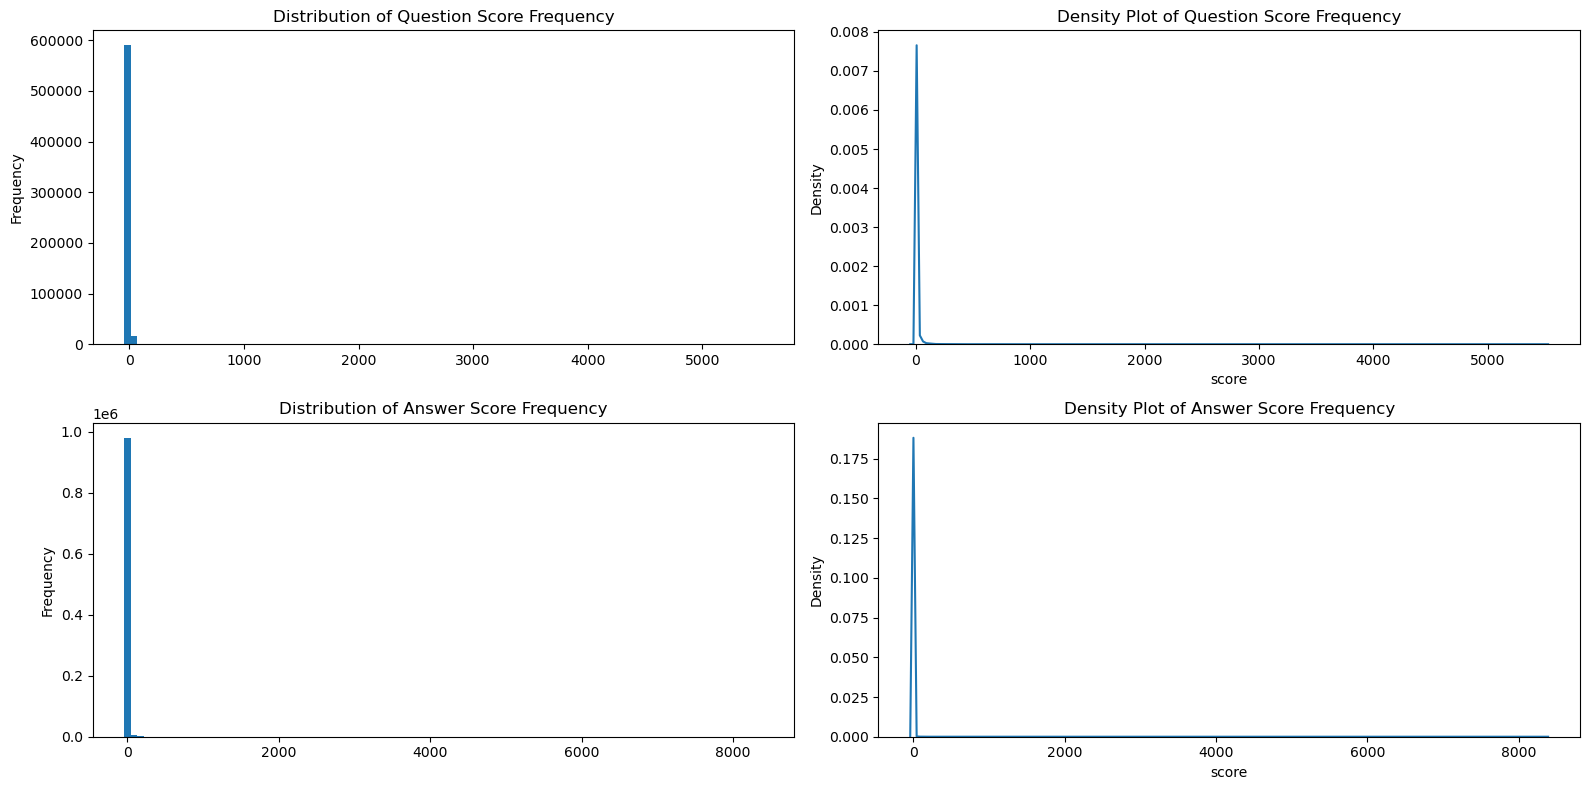

In [68]:
# Histogram and kds plot of score frequency questions and anwers
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Questions hist
ax0 = axs[0][0]

questions['score'].plot(kind='hist', bins=100, ax=ax0,
                        title='Distribution of Question Score Frequency')

# Questions kde
ax1 = axs[0][1]

sns.kdeplot(questions['score'], ax=ax1)
ax1.set_title('Density Plot of Question Score Frequency')

# Answers hist
ax2 = axs[1][0]

answers['score'].plot(kind='hist', bins=100, ax=ax2,
                      title='Distribution of Answer Score Frequency')

# Answers kde
ax3 = axs[1][1]

sns.kdeplot(answers['score'], ax=ax3)
ax3.set_title('Density Plot of Answer Score Frequency')

# Show
fig.tight_layout()
plt.show()

In [77]:
# Questions and answers score descriptives
ques_score_summary = questions['score'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99])
answer_score_summary = answers['score'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99])

print('Questions Scores Summary:')
print()
print(ques_score_summary)
print()
print('Answers Scores Summary:')
print()
print(answer_score_summary)

Questions Scores Summary:

count    607282.000000
mean          2.283137
std          19.285578
min         -44.000000
1%           -3.000000
5%           -1.000000
10%           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
90%           4.000000
95%           7.000000
99%          27.000000
max        5524.000000
Name: score, dtype: float64

Answers Scores Summary:

count    987122.000000
mean          3.028437
std          21.263246
min         -38.000000
1%           -1.000000
5%            0.000000
10%           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
90%           5.000000
95%           9.000000
99%          33.000000
max        8384.000000
Name: score, dtype: float64


In [80]:
# View question rows with scores > 99th percentile
print('Questions with score > 27 (99th percentile)')
questions[questions['score'] > 27]

Questions with score > 33 (99th percentile)


,id,owneruserid,creationdate,score,title,body
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
5,742,189.0,2008-08-03T15:55:28Z,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja..."
7,773,207.0,2008-08-03T18:27:09Z,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...
8,972,145.0,2008-08-04T02:17:51Z,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...
...,...,...,...,...,...,...
597533,39779538,178732.0,2016-09-29T20:35:58Z,35,"How to get lineno of ""end-of-statement"" in Pyt...",<p>I am trying to work on a script that manipu...
599214,39843488,336527.0,2016-10-04T03:00:56Z,41,How to make an integer larger than any other i...,<p>Note: while the accepted answer achieves th...
600687,39903242,5149992.0,2016-10-06T18:29:51Z,32,Is there a more Pythonic way to combine an Els...,<p>I have a piece of code that searches AutoCA...
602793,39980323,6260170.0,2016-10-11T14:59:23Z,72,Dictionaries are ordered in Python 3.6,"<p>Dictionaries are ordered in Python 3.6, unl..."


In [81]:
# View answer rows with scores > 99th percentile
print('Ansers with score > 33 (99th percentile)')
answers[answers['score'] > 33]

Ansers with score > 33 (99th percentile)


,id,owneruserid,creationdate,parentid,score,body
13,783,189.0,2008-08-03T18:40:09Z,773,52,<p>Can you show us your code?</p>\n\n<p>The ex...
19,1484,2089740.0,2008-08-04T18:34:45Z,1476,57,<pre><code>&gt;&gt;&gt; print int('01010101111...
24,1857,2089740.0,2008-08-05T03:27:03Z,1854,341,<pre><code>&gt;&gt;&gt; import os\n&gt;&gt;&gt...
26,1871,216.0,2008-08-05T03:57:22Z,1854,112,"<p>Dang -- lbrandy beat me to the punch, but t..."
27,1879,116.0,2008-08-05T04:13:53Z,1854,91,<p>For the record here's the results on Mac:</...
...,...,...,...,...,...,...
970166,39619467,1204143.0,2016-09-21T14:30:11Z,39618943,287,<p>The simple answer is because <code>3*0.1 !=...
977244,39843523,674039.0,2016-10-04T03:04:16Z,39843488,61,"<p>Since python integers are unbounded, you ha..."
979093,39903519,3155933.0,2016-10-06T18:45:36Z,39903242,63,<p>Use <code>dict.get()</code> which will retu...
981661,39980744,4952130.0,2016-10-11T15:17:53Z,39980323,57,<blockquote>\n <p>How does the Python 3.6 dic...


### Distribution of reviews over time

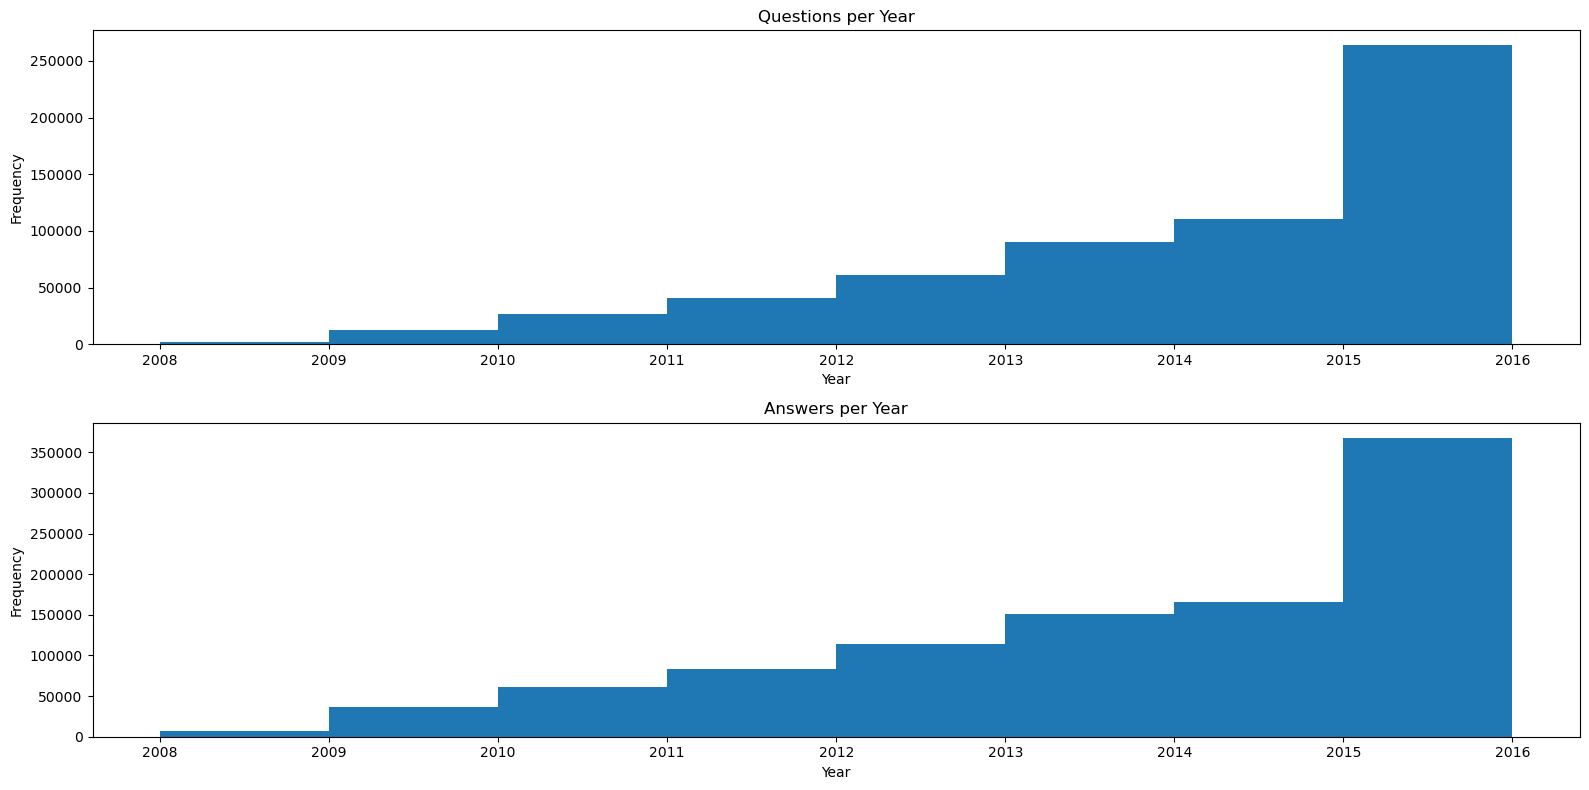

In [150]:
# Subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Questions per year
ax0 = axs[0]

questions['creation_year'].plot(kind='hist', ax=ax0,
                                title='Questions per Year',
                                xlabel='Year', bins=8)

# Answers per year
ax1 = axs[1]

answers['creation_year'].plot(kind='hist', ax=ax1,
                              title='Answers per Year',
                              xlabel='Year', bins=8)

# Display
fig.tight_layout()
plt.show()

### Wordcloud

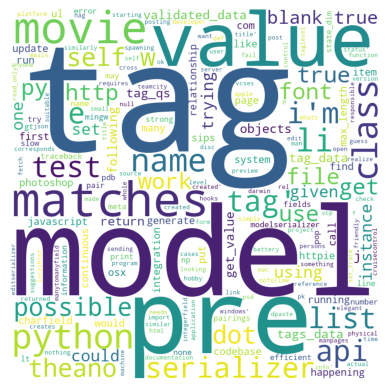

In [ ]:
questions_text = questions['body_normalized'].values
stopwords = nltk_stopwords.words('english')

questions_wordcloud = WordCloud(width=800, height=800,
                                background_color='white',
                                stopwords=stopwords,
                                min_font_size=10).generate(str(questions_text))

plt.imshow(questions_wordcloud)
plt.axis('off')
plt.show()

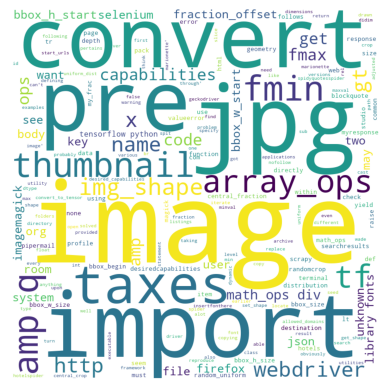

In [ ]:
answers_text = answers['body_normalized'].values

answers_wordcloud = WordCloud(width=800, height=800,
                                background_color='white',
                                stopwords=stopwords,
                                min_font_size=10).generate(str(answers_text))

plt.imshow(answers_wordcloud)
plt.axis('off')
plt.show()